In [1]:
library(tidyverse)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


In [2]:
data_path <- '../data/'
cohort_df <- read_csv(paste0(data_path, 'cohort.csv'))

Parsed with column specification:
cols(
  subject_id = col_integer(),
  hadm_id = col_integer(),
  icustay_id = col_integer(),
  intime = col_datetime(format = ""),
  outtime = col_datetime(format = ""),
  suspected_infection_time_poe = col_datetime(format = ""),
  window_start = col_datetime(format = ""),
  window_end = col_datetime(format = ""),
  hospital_expire_flag = col_integer()
)


In [7]:
get_time_intervals <- function(start, end) {
    
    interval_times <- seq(start, end, by = '4 hour')
    interval_start_time <- interval_times[1:length(interval_times) -1]
    interval_end_time <- interval_times[2:length(interval_times)]
    return(data.frame(interval_start_time, interval_end_time))
}

In [8]:
interval_times_df <- cohort_df %>% 
                        group_by(subject_id, hadm_id, icustay_id) %>% 
                        do(get_time_intervals(.$window_start, .$window_end))

In [9]:
dim(interval_times_df)

[1] 330210      5

### Vassopressors

In [10]:
# Load some vassopressors
vassopressor_cv_df <- read_csv(paste0(data_path, 'vassopressors_cv_cohort.csv'))
vassopressor_mv_df <- read_csv(paste0(data_path, 'vassopressors_mv_cohort.csv'))

Parsed with column specification:
cols(
  icustay_id = col_integer(),
  charttime = col_datetime(format = ""),
  itemid = col_integer(),
  stopped = col_character(),
  rate = col_character(),
  amount = col_double()
)
Parsed with column specification:
cols(
  icustay_id = col_integer(),
  linkorderid = col_integer(),
  starttime = col_datetime(format = ""),
  endtime = col_datetime(format = ""),
  itemid = col_integer(),
  rate = col_double(),
  amount = col_double()
)


In [11]:
max_vassopressor_cv <- interval_times_df %>% 
                                left_join(vassopressor_cv_df) %>% 
                                group_by(subject_id, 
                                       hadm_id, 
                                       icustay_id, 
                                       interval_start_time, 
                                       interval_end_time) %>%
                                filter(charttime > interval_start_time & charttime <= interval_end_time) %>%
                                summarise(max_amount = max(amount))

Joining, by = "icustay_id"


In [13]:
max_vassopressor_mv <- interval_times_df %>% 
                                left_join(vassopressor_mv_df) %>% 
                                group_by(subject_id, 
                                           hadm_id, 
                                           icustay_id, 
                                           interval_start_time, 
                                           interval_end_time) %>%
                                filter(endtime > interval_start_time & endtime <= interval_end_time) %>%
                                summarise(max_amount = max(amount)) 

Joining, by = "icustay_id"


In [14]:
# Merge the carevue and metavision data back with the full timeline
# max_vassopressor <- max_vassopressor_cv %>% 
#                         full_join(max_vassopressor_mv) %>% 
#                         right_join(interval_times_df)

Joining, by = c("subject_id", "hadm_id", "icustay_id", "interval_start_time", "interval_end_time", "max_amount")
Joining, by = c("subject_id", "hadm_id", "icustay_id", "interval_start_time", "interval_end_time")


In [78]:
# A function to map the data to quartiles
num2quartile <- function(x) {
#     x <- x[is.na(x)]
    quants <- quantile(x, probs=0:4/4, na.rm = TRUE)
    print(quants)
    return(as.integer(cut(x, quants, include.lowest=TRUE)))
}

In [35]:
# Map to discrete vassopressor states
temp <- max_vassopressor_cv %>% 
                        full_join(max_vassopressor_mv) %>%
                        filter(!is.na(max_amount))
temp$discrete_pressor <- num2quartile(temp$max_amount)
action_df_VP <- temp %>% right_join(interval_times_df) %>% replace_na(list(discrete_pressor = 0))

Joining, by = c("subject_id", "hadm_id", "icustay_id", "interval_start_time", "interval_end_time", "max_amount")
Joining, by = c("subject_id", "hadm_id", "icustay_id", "interval_start_time", "interval_end_time")


### IV Fluids

In [80]:
# Load the fluids
inputevents_cv_df <- read_csv(paste0(data_path, 'inputevents_cv_cohort.csv'))
inputevents_mv_df <- read_csv(paste0(data_path, 'inputevents_mv_cohort.csv'))

Parsed with column specification:
cols(
  subject_id = col_integer(),
  hadm_id = col_integer(),
  icustay_id = col_integer(),
  charttime = col_datetime(format = ""),
  itemid = col_integer(),
  amount = col_double(),
  amountuom = col_character(),
  rate = col_double(),
  rateuom = col_character(),
  storetime = col_datetime(format = ""),
  orderid = col_integer()
)
Parsed with column specification:
cols(
  subject_id = col_integer(),
  hadm_id = col_integer(),
  icustay_id = col_integer(),
  starttime = col_datetime(format = ""),
  endtime = col_datetime(format = ""),
  itemid = col_integer(),
  amount = col_double(),
  amountuom = col_character(),
  rate = col_double(),
  rateuom = col_character(),
  storetime = col_datetime(format = ""),
  orderid = col_integer(),
  ordercategoryname = col_character(),
  secondaryordercategoryname = col_character(),
  ordercategorydescription = col_character(),
  patientweight = col_double(),
  totalamount = col_integer(),
  totalamountuom = col_c

In [81]:
ie_filt_cv <- inputevents_cv_df %>% 
                filter(amountuom == 'ml' & !is.na(amount) & amount >= 0)
ie_filt_mv <- inputevents_mv_df %>% 
                filter(amountuom == 'ml' & !is.na(amount) & amount > 0)

In [82]:
# Pulling out some data.table stuff to go FAST
library(data.table)

ie_filt_cv_dt <- as.data.table(ie_filt_cv, key = 'icustay_id')
ie_filt_mv_dt <- as.data.table(ie_filt_mv, key = 'icustay_id')
interval_times_dt <- as.data.table(interval_times_df, key = 'icustay_id')

In [83]:
total_IV_cv <- interval_times_dt %>% 
                                merge(ie_filt_cv_dt, allow.cartesian = TRUE) %>% 
                                group_by(subject_id,
                                       hadm_id, 
                                       icustay_id, 
                                       interval_start_time, 
                                       interval_end_time) %>%
                                filter(charttime > interval_start_time & charttime <= interval_end_time) %>%
                                summarise(total_amount = sum(amount))

In [84]:
total_IV_mv <- interval_times_dt %>% 
                                merge(ie_filt_mv_dt, allow.cartesian = TRUE) %>% 
                                group_by(subject_id,
                                       hadm_id, 
                                       icustay_id, 
                                       interval_start_time, 
                                       interval_end_time) %>%
                                filter(endtime > interval_start_time & endtime <= interval_end_time) %>%
                                summarise(total_amount = sum(amount))

In [86]:
# Map to discrete vassopressor states
temp <- total_IV_cv %>% 
                        full_join(total_IV_mv) %>%
                        filter(!is.na(total_amount))

temp$discrete_IV <- num2quartile(temp$total_amount)
action_df_IV <- temp %>% right_join(interval_times_df) %>% replace_na(list(discrete_IV = 0))

Joining, by = c("subject_id", "hadm_id", "icustay_id", "interval_start_time", "interval_end_time", "total_amount")


          0%          25%          50%          75%         100% 
1.666667e-02 2.192000e+02 4.777688e+02 1.000000e+03 2.901451e+05 


In [94]:
action_df <- action_df_IV %>% full_join(action_df_VP)

Joining, by = c("subject_id", "hadm_id", "icustay_id", "interval_start_time", "interval_end_time")


In [96]:
# Get the final state as discrete_IV + 5 * discrete_pressor
action_df <- action_df %>% mutate(discrete_action = discrete_IV + 5 * discrete_pressor)
head(action_df)

subject_id,hadm_id,icustay_id,interval_start_time,interval_end_time,total_amount,discrete_IV,max_amount,discrete_pressor,discrete_action
4,185777,294638,2191-03-15 00:00:00,2191-03-15 04:00:00,NA,0,NA,0,0
4,185777,294638,2191-03-15 04:00:00,2191-03-15 08:00:00,NA,0,NA,0,0
4,185777,294638,2191-03-15 08:00:00,2191-03-15 12:00:00,NA,0,NA,0,0
4,185777,294638,2191-03-15 12:00:00,2191-03-15 16:00:00,NA,0,NA,0,0
4,185777,294638,2191-03-15 16:00:00,2191-03-15 20:00:00,NA,0,NA,0,0
4,185777,294638,2191-03-15 20:00:00,2191-03-16 00:00:00,NA,0,NA,0,0


In [ ]:
action_df <- action_df %>% rename(total_IV = total_amount, max_VP = max_amount)

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 314381 rows containing missing values (geom_point).”

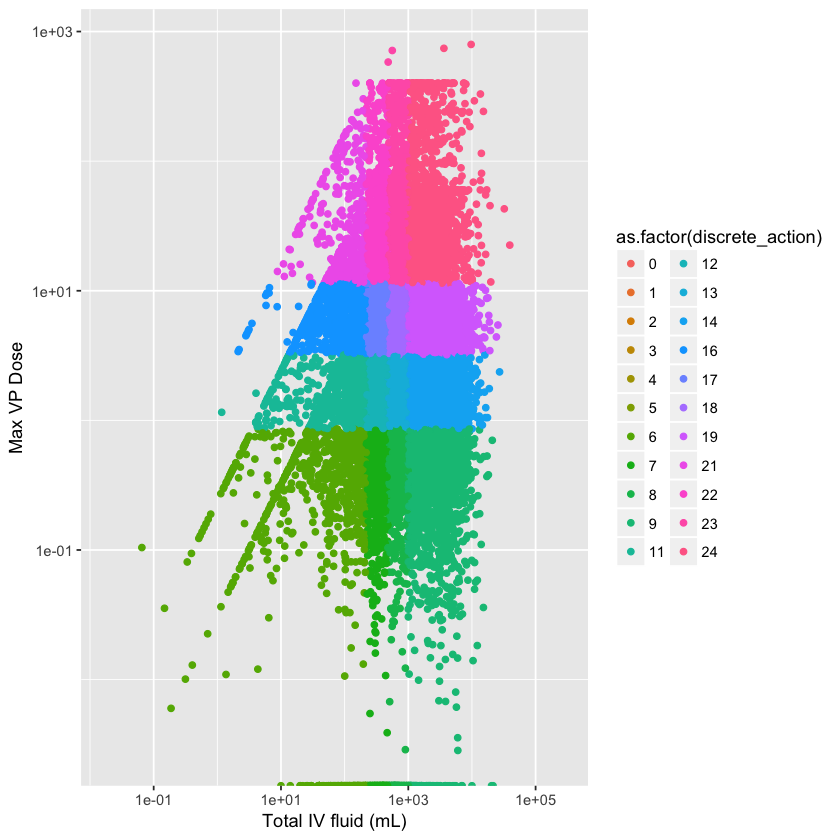

In [109]:
# check to make sure everything is ok

ggplot(action_df, aes(total_IV, max_VP, color = as.factor(discrete_action))) + 
            geom_point() + scale_y_log10() + scale_x_log10() + xlab('Total IV fluid (mL)') + ylab('Max VP Dose')

In [110]:
write_csv(action_df, paste0(data_path, 'action_df.csv'))
write_csv(interval_times_df, paste0(data_path, 'interval_times_df.csv'))